# Distributed Training of Neural Network Models


Below is the basic implementation of Federated Learning code for 2 clients and a server for one communication round using the MNIST dataset.

Your task for this lab is to utilize this code as a benchmark and accomplish  the following objectives:

1. Comment each section of the code to understand its functionality.

2. Experiment with different neural network architectures, varying the number of layers and activation functions

3. Assess the model's performance (accuracy, precision, recall, and f-score) as the number of clients changes. Utilize 2, 4, 6, 8, and 10 clients, and plot a graph illustrating the model's performance across varying client counts.

4. Introduce one dishonest client for a any sepcific number of clients of your choice. For this client, assign some training labels ('y_train') to a specific label, such as '4'. Analyze how the performance ((accuracy, precision, recall, and f-score)) of the global model is affected by the presence of a dishonest client. Find approximately how many labels need to be maliciously altered so that the performance degrades.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras import backend as K
import random

In [2]:
np.random.seed(2297667) # Set seed for numpy. Put your SID instead of number '42'
random.seed(2297667) # Set seed for Python's built-in random number generator.  Put your SID instead of number '42'
tf.random.set_seed(2297667) # Set seed for TensorFlow. Put your SID instead of number '42'
K.clear_session()

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [5]:
# Define client functions
def create_client_model():
    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def train_client_model(model, x_train, y_train, epochs=5):
    model.fit(x_train, y_train, epochs=epochs, verbose=1)
    return model

### 2 Clients

In [7]:
# Split data into two clients
x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

In [8]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
print()
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)


Epoch 1/5


938/938 [==============================] - 2s 2ms/step - loss: 0.3426 - accuracy: 0.9026
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1554 - accuracy: 0.9549
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1087 - accuracy: 0.9688
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0799 - accuracy: 0.9765
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0617 - accuracy: 0.9824

Epoch 1/5
938/938 [==============================] - 5s 4ms/step - loss: 0.3363 - accuracy: 0.9044
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1574 - accuracy: 0.9548
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1075 - accuracy: 0.9674
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0791 - accuracy: 0.9772
Epoch 5/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0617 - accuracy: 0.9812


In [9]:
# Federated averaging
def federated_average_weights(weights1, weights2):
    new_weights = []
    for w1, w2 in zip(weights1, weights2):
        new_weights.append((w1 + w2) / 2)
    return new_weights

In [10]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights())

In [11]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [12]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 0.3636 - accuracy: 0.9060 - 1s/epoch - 4ms/step
Test accuracy: 0.906000018119812


In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [14]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step
(10000, 10)


In [15]:
two_client_classification_report = classification_report(y_test, predictions)
print(two_client_classification_report)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       980
           1       0.99      0.97      0.98      1135
           2       0.88      0.95      0.91      1032
           3       0.85      0.96      0.90      1010
           4       0.96      0.95      0.95       982
           5       0.73      0.91      0.81       892
           6       0.94      0.85      0.89       958
           7       0.92      0.96      0.94      1028
           8       0.95      0.75      0.84       974
           9       0.89      0.92      0.91      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000



In [16]:
two_client_accuracy = accuracy_score(y_test,predictions)
two_client_precision = precision_score(y_test,predictions, average='weighted')
two_client_recall = recall_score(y_test,predictions, average='weighted')
two_client_f1 = f1_score(y_test,predictions, average='weighted')
print("Accuracy test set: ", two_client_accuracy)
print("Precision test set: ", two_client_precision)
print("Recall test set: ", two_client_recall )
print("F1-Score test set: ", two_client_f1)

Accuracy test set:  0.906
Precision test set:  0.9137041502903684
Recall test set:  0.906
F1-Score test set:  0.9062726098001964


# Lab Logbook requirement: Document the following in lablogbook

1. Plot the model's performance for the number of clients ranging from 2, 4, 6, 8, and 10.

2. For any specified number of clients, compare the model's performance when one (or more) dishonest clients are present. Plot the performance metrics before and after the presence of dishonest clients.




# Challenges (Optional):

## The above code is for one communication round. Write code for multiple communication rounds. In each communication round, clients will train the model on a new dataset. Then the server will merge all these models. Subsequently, the clients will retrain the merged model in the next communication round.



### 4 Clients

In [17]:
# Split data into two clients
x_train_ca, x_train_cb, y_train_ca, y_train_cb = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train_ca, y_train_ca, test_size=0.5, random_state=42)
x_train_c3, x_train_c4, y_train_c3, y_train_c4 = train_test_split(x_train_cb, y_train_cb, test_size=0.5, random_state=42)

In [18]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()


client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
print()
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)
print()
client3_model = train_client_model(client3_model, x_train_c3, y_train_c3)
print()
client4_model = train_client_model(client4_model, x_train_c4, y_train_c4)

Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.4616 - accuracy: 0.8696
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2210 - accuracy: 0.9369
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1566 - accuracy: 0.9546
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.1211 - accuracy: 0.9653
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0930 - accuracy: 0.9747

Epoch 1/5
469/469 [==============================] - 3s 4ms/step - loss: 0.4303 - accuracy: 0.8807
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2075 - accuracy: 0.9402
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1469 - accuracy: 0.9577
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1104 - accuracy: 0.9683
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0851 - accuracy: 0.9755

Epoch 1/

In [19]:
# Federated averaging
def federated_average_weights(weights1, weights2, weight3, weight4):
    new_weights = []
    for w1, w2, w3, w4 in zip(weights1, weights2, weight3, weight4):
        new_weights.append((w1 + w2 + w3 +w4) / 4)
    return new_weights

In [20]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights())

In [21]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [22]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 0.9856 - accuracy: 0.7037 - 909ms/epoch - 3ms/step
Test accuracy: 0.7037000060081482


In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [24]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step
(10000, 10)


In [25]:
four_client_classification_report = classification_report(y_test, predictions)
print(four_client_classification_report)

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       980
           1       0.88      0.99      0.93      1135
           2       0.80      0.92      0.85      1032
           3       0.94      0.77      0.85      1010
           4       0.92      0.45      0.60       982
           5       0.47      0.93      0.62       892
           6       0.92      0.79      0.85       958
           7       0.41      0.96      0.58      1028
           8       1.00      0.07      0.14       974
           9       0.91      0.34      0.49      1009

    accuracy                           0.70     10000
   macro avg       0.82      0.70      0.68     10000
weighted avg       0.82      0.70      0.68     10000



In [26]:
four_client_accuracy = accuracy_score(y_test,predictions)
four_client_precision = precision_score(y_test,predictions, average='weighted')
four_client_recall = recall_score(y_test,predictions, average='weighted')
four_client_f1 = f1_score(y_test,predictions, average='weighted')
print("Accuracy test set: ", four_client_accuracy)
print("Precision test set: ", four_client_precision)
print("Recall test set: ", four_client_recall )
print("F1-Score test set: ", four_client_f1)

Accuracy test set:  0.7037
Precision test set:  0.8239934467650722
Recall test set:  0.7037
F1-Score test set:  0.6822709639898848


### 6 Clients

In [27]:
# Split data into two clients
x_train_c1 = x_train[0:10000]
x_train_c2 = x_train[10000:20000]
x_train_c3 = x_train[20000:30000]
x_train_c4 = x_train[30000:40000]
x_train_c5 = x_train[40000:50000]
x_train_c6 = x_train[50000:59999]
y_train_c1 = y_train[0:10000]
y_train_c2 = y_train[10000:20000]
y_train_c3 = y_train[20000:30000]
y_train_c4 = y_train[30000:40000]
y_train_c5 = y_train[40000:50000]
y_train_c6 = y_train[50000:59999]

In [28]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()


client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
print()
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)
print()
client3_model = train_client_model(client3_model, x_train_c3, y_train_c3)
print()
client4_model = train_client_model(client4_model, x_train_c4, y_train_c4)
print()
client5_model = train_client_model(client5_model, x_train_c5, y_train_c5)
print()
client6_model = train_client_model(client6_model, x_train_c6, y_train_c6)

Epoch 1/5
313/313 [==============================] - 2s 4ms/step - loss: 0.5129 - accuracy: 0.8593
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2453 - accuracy: 0.9301
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1809 - accuracy: 0.9492
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1400 - accuracy: 0.9603
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1094 - accuracy: 0.9702

Epoch 1/5
313/313 [==============================] - 2s 4ms/step - loss: 0.5379 - accuracy: 0.8469
Epoch 2/5
313/313 [==============================] - 1s 4ms/step - loss: 0.2409 - accuracy: 0.9332
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1721 - accuracy: 0.9524
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1294 - accuracy: 0.9658
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0989 - accuracy: 0.9739

Epoch 1/

In [29]:
# Federated averaging
def federated_average_weights(weight1, weight2, weight3, weight4, weight5, weight6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weight1, weight2, weight3, weight4, weight5, weight6):
        new_weights.append((w1 + w2 + w3 +w4 +w5 +w6) / 6)
    return new_weights

In [30]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights(), 
                                               client5_model.get_weights(), client6_model.get_weights())

In [31]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [32]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 1.3447 - accuracy: 0.5255 - 972ms/epoch - 3ms/step
Test accuracy: 0.5254999995231628


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step
(10000, 10)


In [35]:
six_client_classification_report = classification_report(y_test, predictions)
print(six_client_classification_report)

              precision    recall  f1-score   support

           0       1.00      0.16      0.27       980
           1       0.98      0.93      0.95      1135
           2       0.60      0.95      0.74      1032
           3       0.97      0.29      0.45      1010
           4       0.97      0.34      0.51       982
           5       0.19      0.99      0.32       892
           6       0.98      0.32      0.48       958
           7       0.75      0.92      0.83      1028
           8       0.00      0.00      0.00       974
           9       0.90      0.30      0.45      1009

    accuracy                           0.53     10000
   macro avg       0.73      0.52      0.50     10000
weighted avg       0.74      0.53      0.51     10000



C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
six_client_accuracy = accuracy_score(y_test,predictions)
six_client_precision = precision_score(y_test,predictions, average='weighted')
six_client_recall = recall_score(y_test,predictions, average='weighted')
six_client_f1 = f1_score(y_test,predictions, average='weighted')
print("Accuracy test set: ", six_client_accuracy)
print("Precision test set: ", six_client_precision)
print("Recall test set: ", six_client_recall )
print("F1-Score test set: ", six_client_f1)

Accuracy test set:  0.5255
Precision test set:  0.7437409603473603
Recall test set:  0.5255
F1-Score test set:  0.5113461237751503


C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 8 Clients

In [37]:
# Split data into two clients
x_train_caa, x_train_cbb, y_train_caa, y_train_cbb = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

x_train_ca, x_train_cb, y_train_ca, y_train_cb = train_test_split(x_train_caa, y_train_caa, test_size=0.5, random_state=42)
x_train_cc, x_train_cd, y_train_cc, y_train_cd = train_test_split(x_train_cbb, y_train_cbb, test_size=0.5, random_state=42)

x_train_c1, x_train_c2, y_train_c1, y_train_c2 = train_test_split(x_train_ca, y_train_ca, test_size=0.5, random_state=42)
x_train_c3, x_train_c4, y_train_c3, y_train_c4 = train_test_split(x_train_cb, y_train_cb, test_size=0.5, random_state=42)
x_train_c5, x_train_c6, y_train_c5, y_train_c6 = train_test_split(x_train_cc, y_train_cc, test_size=0.5, random_state=42)
x_train_c7, x_train_c8, y_train_c7, y_train_c8 = train_test_split(x_train_cd, y_train_cd, test_size=0.5, random_state=42)

In [38]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()


client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
print()
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)
print()
client3_model = train_client_model(client3_model, x_train_c3, y_train_c3)
print()
client4_model = train_client_model(client4_model, x_train_c4, y_train_c4)
print()
client5_model = train_client_model(client5_model, x_train_c5, y_train_c5)
print()
client6_model = train_client_model(client6_model, x_train_c6, y_train_c6)
print()
client7_model = train_client_model(client7_model, x_train_c7, y_train_c7)
print()
client8_model = train_client_model(client8_model, x_train_c8, y_train_c8)

Epoch 1/5
235/235 [==============================] - 2s 4ms/step - loss: 0.6095 - accuracy: 0.8265
Epoch 2/5
235/235 [==============================] - 1s 4ms/step - loss: 0.2891 - accuracy: 0.9165
Epoch 3/5
235/235 [==============================] - 1s 4ms/step - loss: 0.2209 - accuracy: 0.9383
Epoch 4/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1715 - accuracy: 0.9529
Epoch 5/5
235/235 [==============================] - 1s 4ms/step - loss: 0.1388 - accuracy: 0.9615

Epoch 1/5
235/235 [==============================] - 2s 4ms/step - loss: 0.6280 - accuracy: 0.8236
Epoch 2/5
235/235 [==============================] - 1s 3ms/step - loss: 0.2842 - accuracy: 0.9165
Epoch 3/5
235/235 [==============================] - 1s 4ms/step - loss: 0.2105 - accuracy: 0.9401
Epoch 4/5
235/235 [==============================] - 1s 3ms/step - loss: 0.1616 - accuracy: 0.9521
Epoch 5/5
235/235 [==============================] - 1s 3ms/step - loss: 0.1248 - accuracy: 0.9648

Epoch 1/

In [39]:
# Federated averaging
def federated_average_weights(weight1, weight2, weight3, weight4, weight5, weight6, weight7, weight8):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8 in zip(weight1, weight2, weight3, weight4, weight5, weight6, weight7, weight8):
        new_weights.append((w1 + w2 + w3 +w4 +w5 +w6 + w7+ w8) / 8)
    return new_weights

In [40]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights(), 
                                               client5_model.get_weights(), client6_model.get_weights(), client7_model.get_weights(), client8_model.get_weights())

In [41]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [42]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 1.4272 - accuracy: 0.6055 - 895ms/epoch - 3ms/step
Test accuracy: 0.6054999828338623


In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [44]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step
(10000, 10)


In [45]:
eight_client_classification_report = classification_report(y_test, predictions)
print(eight_client_classification_report)

              precision    recall  f1-score   support

           0       0.97      0.26      0.41       980
           1       0.94      0.95      0.95      1135
           2       0.88      0.87      0.87      1032
           3       0.81      0.80      0.81      1010
           4       0.88      0.75      0.81       982
           5       0.25      0.94      0.40       892
           6       0.99      0.43      0.60       958
           7       0.50      0.96      0.66      1028
           8       0.50      0.00      0.00       974
           9       0.91      0.04      0.08      1009

    accuracy                           0.61     10000
   macro avg       0.76      0.60      0.56     10000
weighted avg       0.77      0.61      0.57     10000



In [46]:
eight_client_accuracy = accuracy_score(y_test,predictions)
eight_client_precision = precision_score(y_test,predictions, average='weighted')
eight_client_recall = recall_score(y_test,predictions, average='weighted')
eight_client_f1 = f1_score(y_test,predictions, average='weighted')
print("Accuracy test set: ", eight_client_accuracy)
print("Precision test set: ", eight_client_precision)
print("Recall test set: ", eight_client_recall )
print("F1-Score test set: ", eight_client_f1)

Accuracy test set:  0.6055
Precision test set:  0.7707806632334815
Recall test set:  0.6055
F1-Score test set:  0.5674750619495673


### 10 Clients

In [47]:
# Split data into two clients
x_train_c1 = x_train[0:6000]
x_train_c2 = x_train[6000:12000]
x_train_c3 = x_train[12000:18000]
x_train_c4 = x_train[18000:24000]
x_train_c5 = x_train[24000:30000]
x_train_c6 = x_train[30000:36000]
x_train_c7 = x_train[36000:42000]
x_train_c8 = x_train[42000:48000]
x_train_c9 = x_train[48000:54000]
x_train_c10 = x_train[54000:60000]

y_train_c1 = y_train[0:6000]
y_train_c2 = y_train[6000:12000]
y_train_c3 = y_train[12000:18000]
y_train_c4 = y_train[18000:24000]
y_train_c5 = y_train[24000:30000]
y_train_c6 = y_train[30000:36000]
y_train_c7 = y_train[36000:42000]
y_train_c8 = y_train[42000:48000]
y_train_c9 = y_train[48000:54000]
y_train_c10 = y_train[54000:60000]

In [48]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()
client7_model = create_client_model()
client8_model = create_client_model()
client9_model = create_client_model()
client10_model = create_client_model()

client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
print()
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)
print()
client3_model = train_client_model(client3_model, x_train_c3, y_train_c3)
print()
client4_model = train_client_model(client4_model, x_train_c4, y_train_c4)
print()
client5_model = train_client_model(client5_model, x_train_c5, y_train_c5)
print()
client6_model = train_client_model(client6_model, x_train_c6, y_train_c6)
print()
client7_model = train_client_model(client7_model, x_train_c7, y_train_c7)
print()
client8_model = train_client_model(client8_model, x_train_c8, y_train_c8)
print()
client9_model = train_client_model(client9_model, x_train_c9, y_train_c9)
print()
client10_model = train_client_model(client10_model, x_train_c10, y_train_c10)

Epoch 1/5
188/188 [==============================] - 2s 4ms/step - loss: 0.6476 - accuracy: 0.8247
Epoch 2/5
188/188 [==============================] - 1s 3ms/step - loss: 0.2728 - accuracy: 0.9270
Epoch 3/5
188/188 [==============================] - 1s 3ms/step - loss: 0.2023 - accuracy: 0.9442
Epoch 4/5
188/188 [==============================] - 1s 3ms/step - loss: 0.1558 - accuracy: 0.9573
Epoch 5/5
188/188 [==============================] - 1s 3ms/step - loss: 0.1222 - accuracy: 0.9677

Epoch 1/5
188/188 [==============================] - 2s 4ms/step - loss: 0.6425 - accuracy: 0.8240
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 0.2846 - accuracy: 0.9172
Epoch 3/5
188/188 [==============================] - 1s 4ms/step - loss: 0.2118 - accuracy: 0.9408
Epoch 4/5
188/188 [==============================] - 1s 4ms/step - loss: 0.1667 - accuracy: 0.9533
Epoch 5/5
188/188 [==============================] - 1s 4ms/step - loss: 0.1345 - accuracy: 0.9635

Epoch 1/

In [49]:
# Federated averaging
def federated_average_weights(weight1, weight2, weight3, weight4, weight5, weight6, weight7, weight8, weight9, weight10):
    new_weights = []
    for w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 in zip(weight1, weight2, weight3, weight4, weight5, weight6, weight7, weight8, weight9, weight10):
        new_weights.append((w1 + w2 + w3 +w4 +w5 +w6 + w7 +w8 +w9 +w10) / 10)
    return new_weights

In [50]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights(),
                                               client5_model.get_weights(), client6_model.get_weights(), client7_model.get_weights(), client8_model.get_weights(),
                                               client9_model.get_weights(), client10_model.get_weights())

In [51]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [52]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 1.6952 - accuracy: 0.4355 - 1s/epoch - 4ms/step
Test accuracy: 0.43549999594688416


In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [54]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step
(10000, 10)


In [55]:
ten_client_classification_report = classification_report(y_test, predictions)
print(ten_client_classification_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.99      0.43      0.60      1135
           2       0.55      0.90      0.69      1032
           3       0.98      0.37      0.54      1010
           4       0.70      0.64      0.67       982
           5       0.24      0.97      0.39       892
           6       1.00      0.03      0.06       958
           7       0.35      0.98      0.51      1028
           8       0.00      0.00      0.00       974
           9       0.80      0.01      0.02      1009

    accuracy                           0.44     10000
   macro avg       0.56      0.44      0.35     10000
weighted avg       0.57      0.44      0.36     10000



C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
ten_client_accuracy = accuracy_score(y_test,predictions)
ten_client_precision = precision_score(y_test,predictions, average='weighted')
ten_client_recall = recall_score(y_test,predictions, average='weighted')
ten_client_f1 = f1_score(y_test,predictions, average='weighted')
print("Accuracy test set: ", ten_client_accuracy)
print("Precision test set: ", ten_client_precision)
print("Recall test set: ", ten_client_recall )
print("F1-Score test set: ", ten_client_f1)

Accuracy test set:  0.4355
Precision test set:  0.5712943522605463
Recall test set:  0.4355
F1-Score test set:  0.355490720202256


C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
import pandas as pd

ErrorMetrics = []

test_accuracy = [two_client_accuracy, four_client_accuracy, six_client_accuracy, eight_client_accuracy, ten_client_accuracy]
test_precision = [two_client_precision, four_client_precision, six_client_precision, eight_client_precision, ten_client_precision]
test_recall = [two_client_recall,four_client_recall,six_client_recall, eight_client_recall,ten_client_recall]
test_f1 = [two_client_f1,four_client_f1, six_client_f1,eight_client_f1, ten_client_f1]

ErrorMetrics.append(test_accuracy)
ErrorMetrics.append(test_precision)
ErrorMetrics.append(test_recall)
ErrorMetrics.append(test_f1)

print(ErrorMetrics)

ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = [2,4,6,8,10]
ErrorMetrics_pd = ErrorMetrics_pd.T
ErrorMetrics_pd.columns = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
ErrorMetrics_pd

[[0.906, 0.7037, 0.5255, 0.6055, 0.4355], [0.9137041502903684, 0.8239934467650722, 0.7437409603473603, 0.7707806632334815, 0.5712943522605463], [0.906, 0.7037, 0.5255, 0.6055, 0.4355], [0.9062726098001964, 0.6822709639898848, 0.5113461237751503, 0.5674750619495673, 0.355490720202256]]


,Accuracy,Precision,Recall,F1_Score
2,0.9060,0.913704,0.9060,0.906273
4,0.7037,0.823993,0.7037,0.682271
6,0.5255,0.743741,0.5255,0.511346
8,0.6055,0.770781,0.6055,0.567475
10,0.4355,0.571294,0.4355,0.355491


<Axes: >

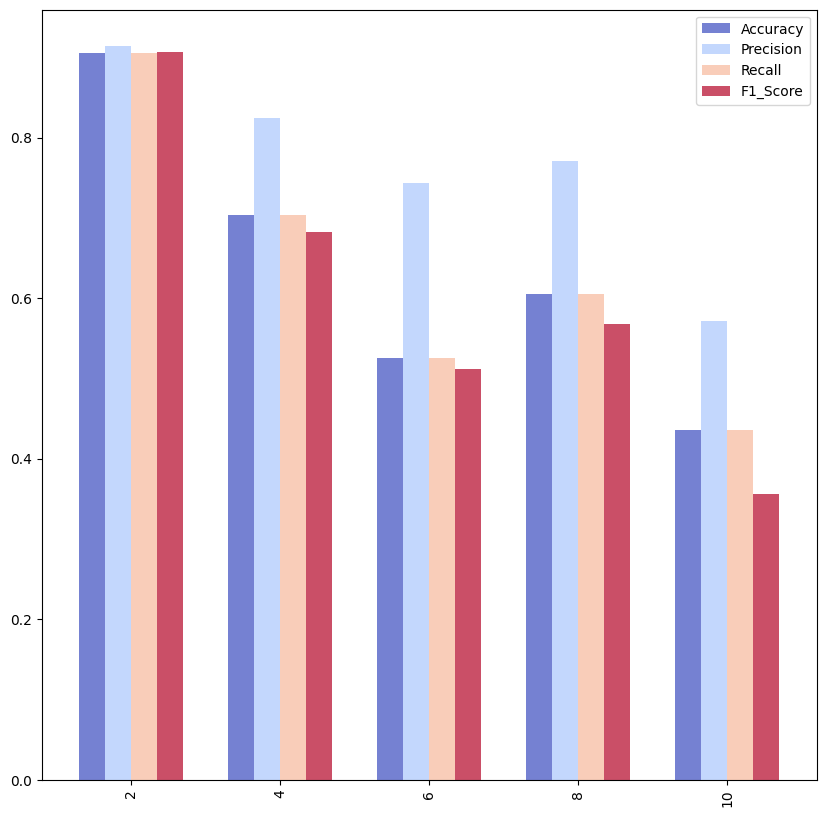

In [72]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,10))
ErrorMetrics_pd.plot.bar(width = 0.7, alpha = 0.7, cmap = 'coolwarm', ax = ax)

## Hacker

### 6 Clients with two Hackers

In [ ]:
y_train[0:2500]

In [27]:
# Split data into two clients
x_train_c1 = x_train[0:10000]
x_train_c2 = x_train[10000:20000]
x_train_c3 = x_train[20000:30000]
x_train_c4 = x_train[30000:40000]
x_train_c5 = x_train[40000:50000]
x_train_c6 = x_train[50000:59999]
y_train_c1 = y_train[0:10000]
y_train_c2 = y_train[10000:20000]
y_train_c3 = y_train[20000:30000]
y_train_c4 = y_train[30000:40000]
y_train_c5 = y_train[40000:50000]
y_train_c6 = y_train[50000:59999]

In [28]:
# Create and train client models
client1_model = create_client_model()
client2_model = create_client_model()
client3_model = create_client_model()
client4_model = create_client_model()
client5_model = create_client_model()
client6_model = create_client_model()


client1_model = train_client_model(client1_model, x_train_c1, y_train_c1)
print()
client2_model = train_client_model(client2_model, x_train_c2, y_train_c2)
print()
client3_model = train_client_model(client3_model, x_train_c3, y_train_c3)
print()
client4_model = train_client_model(client4_model, x_train_c4, y_train_c4)
print()
client5_model = train_client_model(client5_model, x_train_c5, y_train_c5)
print()
client6_model = train_client_model(client6_model, x_train_c6, y_train_c6)

Epoch 1/5
313/313 [==============================] - 2s 4ms/step - loss: 0.5129 - accuracy: 0.8593
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2453 - accuracy: 0.9301
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1809 - accuracy: 0.9492
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1400 - accuracy: 0.9603
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1094 - accuracy: 0.9702

Epoch 1/5
313/313 [==============================] - 2s 4ms/step - loss: 0.5379 - accuracy: 0.8469
Epoch 2/5
313/313 [==============================] - 1s 4ms/step - loss: 0.2409 - accuracy: 0.9332
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1721 - accuracy: 0.9524
Epoch 4/5
313/313 [==============================] - 1s 4ms/step - loss: 0.1294 - accuracy: 0.9658
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0989 - accuracy: 0.9739

Epoch 1/

In [29]:
# Federated averaging
def federated_average_weights(weight1, weight2, weight3, weight4, weight5, weight6):
    new_weights = []
    for w1, w2, w3, w4, w5, w6 in zip(weight1, weight2, weight3, weight4, weight5, weight6):
        new_weights.append((w1 + w2 + w3 +w4 +w5 +w6) / 6)
    return new_weights

In [30]:
# Aggregate models
aggregated_weights = federated_average_weights(client1_model.get_weights(), client2_model.get_weights(), client3_model.get_weights(), client4_model.get_weights(), 
                                               client5_model.get_weights(), client6_model.get_weights())

In [31]:
# Create global model and set weights
global_model = create_client_model()
global_model.set_weights(aggregated_weights)

In [32]:
# Evaluate global model
test_loss, test_acc = global_model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)

313/313 - 1s - loss: 1.3447 - accuracy: 0.5255 - 972ms/epoch - 3ms/step
Test accuracy: 0.5254999995231628


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
predictions = global_model.predict(x_test)
print(predictions.shape)

predictions = list(predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step
(10000, 10)


In [35]:
six_client_classification_report = classification_report(y_test, predictions)
print(six_client_classification_report)

              precision    recall  f1-score   support

           0       1.00      0.16      0.27       980
           1       0.98      0.93      0.95      1135
           2       0.60      0.95      0.74      1032
           3       0.97      0.29      0.45      1010
           4       0.97      0.34      0.51       982
           5       0.19      0.99      0.32       892
           6       0.98      0.32      0.48       958
           7       0.75      0.92      0.83      1028
           8       0.00      0.00      0.00       974
           9       0.90      0.30      0.45      1009

    accuracy                           0.53     10000
   macro avg       0.73      0.52      0.50     10000
weighted avg       0.74      0.53      0.51     10000



C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
six_client_accuracy = accuracy_score(y_test,predictions)
six_client_precision = precision_score(y_test,predictions, average='weighted')
six_client_recall = recall_score(y_test,predictions, average='weighted')
six_client_f1 = f1_score(y_test,predictions, average='weighted')
print("Accuracy test set: ", six_client_accuracy)
print("Precision test set: ", six_client_precision)
print("Recall test set: ", six_client_recall )
print("F1-Score test set: ", six_client_f1)

Accuracy test set:  0.5255
Precision test set:  0.7437409603473603
Recall test set:  0.5255
F1-Score test set:  0.5113461237751503


C:\Users\sasen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
